# House Price Prediction

## Explore Stacked Models

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from scipy.stats import skew

In [2]:
# read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# remove outliers (with GrLivArea > 4000)
train = train[train.GrLivArea < 4000]

# get other train info
num_train = train.shape[0]
id_train = train['Id']
y_train = train['SalePrice']
x_train = train.drop(['Id','SalePrice'], axis=1)
print('x_train shape:', x_train.shape)

# get other test info
num_test = test.shape[0]
id_test = test['Id']
x_test = test.drop(['Id'], axis=1)
print('x_test shape:', x_test.shape)

# combine train and test data
comb = pd.concat([x_train, x_test], ignore_index=True)
print('combined shape:', comb.shape)

x_train shape: (1456, 79)
x_test shape: (1459, 79)
combined shape: (2915, 79)


In [3]:
# count NAs for each feature
na_count = comb.isnull().sum()
na_count = na_count[na_count!=0]
print('Number of features with NA:', na_count.shape[0])
print('Inital NA count:')
print(na_count)

Number of features with NA: 34
Inital NA count:
MSZoning           4
LotFrontage      486
Alley           2717
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2907
Fence           2345
MiscFeature     2810
SaleType           1
dtype: int64


In [4]:
# change meaningful NAs to None
target_cols = ['Alley', 'MasVnrType', 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
               'GarageType', 'GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']
comb.loc[:, target_cols] = comb[target_cols].fillna('None')

# LotFrontage: use medium of the same neighborhood
comb.loc[:, ['LotFrontage']] = comb.groupby(['Neighborhood'])['LotFrontage'].transform(
    lambda x : x.fillna(x.median()))

# Utilities: the test set only has Allpub value, and it has only 2 missing values. It's insignificant.
comb.drop(['Utilities'], axis=1, inplace=True)

# Bsmt area/bathroom related: use 0
target_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
comb.loc[:, target_cols] = comb[target_cols].fillna(0)

# Functional: use Typ
comb.loc[:, ['Functional']] = comb['Functional'].fillna('Typ')

# Garage related: use 0
target_cols = ['GarageYrBlt', 'GarageCars', 'GarageArea']
comb.loc[:, target_cols] = comb[target_cols].fillna(0)

# Others: use mode
target_cols = ['MSZoning', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'Electrical', 'KitchenQual', 'SaleType']
vals = comb.loc[:, target_cols].mode()
comb.loc[:, target_cols] = comb[target_cols].fillna(vals.loc[0,:])

# count NAs for each feature again
na_count = comb.isnull().sum()
na_count = na_count[na_count!=0]
print('Number of features with NA:', na_count.shape[0])
print('Post-processing NA count:')
print(na_count)

Number of features with NA: 0
Post-processing NA count:
Series([], dtype: int64)


In [5]:
# convert categorical features to strings
comb['MSSubClass_cat'] = comb['MSSubClass'].astype('str')

# convert ordinal features to numbers
comb = comb.replace({
    'Street' : {'Grvl' : 1, 'Pave' : 2},
    'Alley' : {'Grvl' : 1, 'Pave' : 2},
    'LotShape' : {'IR3' : 1, 'IR2' : 2, 'IR1' : 3, 'Reg' : 4},
    'LandSlope' : {'Sev' : 1, 'Mod' : 2, 'Gtl' : 3},
    'ExterQual' : {'Po' : 1, 'Fa' : 2, 'TA': 3, 'Gd': 4, 'Ex' : 5},
    'ExterCond' : {'Po' : 1, 'Fa' : 2, 'TA': 3, 'Gd': 4, 'Ex' : 5},
    'BsmtQual' : {'None' : 0, 'Po' : 1, 'Fa' : 2, 'TA': 3, 'Gd' : 4, 'Ex' : 5},
    'BsmtCond' : {'None' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
    'BsmtExposure' : {'None' : 0, 'Mn' : 1, 'Av': 2, 'Gd' : 3},
    'BsmtFinType1' : {'None' : 0, 'Unf' : 1, 'LwQ': 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ' : 6},
    'BsmtFinType2' : {'None' : 0, 'Unf' : 1, 'LwQ': 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ' : 6},
    'HeatingQC' : {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
    'KitchenQual' : {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
    'Functional' : {'Sal' : 1, 'Sev' : 2, 'Maj2' : 3, 'Maj1' : 4, 'Mod': 5, 'Min2' : 6, 'Min1' : 7, 'Typ' : 8},
    'FireplaceQu' : {'None' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
    'GarageFinish':{'None':0, 'Unf':1, 'RFn':2, 'Fin':3},
    'GarageQual' : {'None' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
    'GarageCond' : {'None' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
    'PavedDrive' : {'N' : 0, 'P' : 1, 'Y' : 2},
    'PoolQC' : {'None' : 0, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4},
    })

In [6]:
# create more features

# create features for overall scores
comb['OverallScore'] = comb['OverallQual'] * comb['OverallCond']
comb['GarageScore'] = comb['GarageQual'] * comb['GarageCond']
comb['ExterScore'] = comb['ExterQual'] * comb['ExterCond']
comb['KitchenScore'] = comb['KitchenAbvGr'] * comb['KitchenQual']
comb['FireplaceScore'] = comb['Fireplaces'] * comb['FireplaceQu']
comb['GarageScore2'] = comb['GarageArea'] * comb['GarageQual']
comb['PoolScore'] = comb['PoolArea'] * comb['PoolQC']

# Total number of bathrooms
comb['TotalBath'] = comb['BsmtFullBath'] + (0.5 * comb['BsmtHalfBath']) + comb['FullBath'] + (0.5 * comb['HalfBath'])
# Total square footage for house
comb['TotalSF'] = comb['GrLivArea'] + comb['TotalBsmtSF']
# Total square footage for porch
comb['TotalPorchSF'] = comb['OpenPorchSF'] + comb['EnclosedPorch'] + comb['3SsnPorch'] + comb['ScreenPorch']

# compute years used
def cap_zero(x):
    if x >= 0:
        return x
    return 0

comb['YearsUsedConstr'] = (comb['YrSold'] - comb['YearBuilt']).apply(cap_zero)
comb['YearsUsedRem'] = (comb['YrSold'] - comb['YearRemodAdd']).apply(cap_zero)

print('Shape after feature engineering:', comb.shape)

Shape after feature engineering: (2915, 91)


SalePrice skewness: 1.56434554842


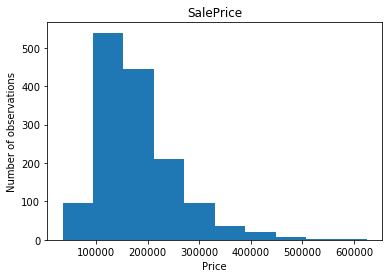

In [7]:
# check skewness of target variable
y_train_skewness = skew(y_train)
print('SalePrice skewness:', y_train_skewness)

# visualize
plt.hist(y_train)
plt.title('SalePrice')
plt.xlabel('Price')
plt.ylabel('Number of observations')
plt.show()
plt.close()

SalePrice (log transformed) skewness: 0.065392611544


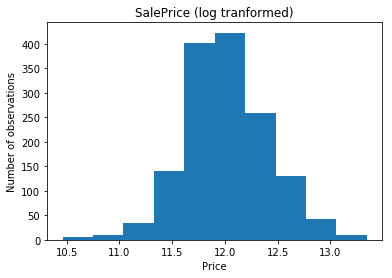

In [8]:
# log transform variables
y_train = np.log1p(y_train)
print('SalePrice (log transformed) skewness:', skew(y_train))

plt.hist(y_train)
plt.title('SalePrice (log tranformed)')
plt.xlabel('Price')
plt.ylabel('Number of observations')
plt.show()
plt.close()

In [9]:
# log transform skewed independent variables
comb_numeric = comb.select_dtypes(include=[np.number])
print('Number of numerical features:', len(comb_numeric.columns))
skewness = comb_numeric.apply(lambda x : skew(x))
skewness = skewness[skewness > 0.6]
skewed_features = list(skewness.index)
print('Number of skewed features:', len(skewed_features))
comb[skewed_features] = np.log1p(comb[skewed_features])

Number of numerical features: 66
Number of skewed features: 35


In [10]:
# use one-hot encoding
comb_oh = pd.get_dummies(comb)
print('Shape after one hot encoding:', comb_oh.shape)

Shape after one hot encoding: (2915, 258)


In [11]:
# extract train and test data from combined
x_train = comb_oh[:num_train]
x_test = comb_oh[num_train:]

In [12]:
# root mean squared log error
def rmsle(pred, gtruth):
    mse = mean_squared_error(gtruth, pred)
    return np.sqrt(mse)

def kfold_cv(x, y, regr, k=3):
    kf = KFold(k)
    x = x.as_matrix()
    y = y.as_matrix()
    error = 0
    for train_idx, test_idx in kf.split(x, y):
        regr.fit(x[train_idx,:], y[train_idx])
        pred = regr.predict(x[test_idx,:])
        error += rmsle(pred, y[test_idx]) / float(k)
    return error

In [13]:
# grid search
def gs_cv(x, y, regr, params):
    gs = GridSearchCV(estimator=regr, param_grid=params, scoring='neg_mean_squared_error')
    gs.fit(X=x, y=y)
    return np.sqrt(-gs.best_score_), gs.best_params_

In [14]:
# create averaging model class
class AveragingModels(object):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        return self.models

    def predict(self, X):
        pred = 0
        for model in self.models:
            pred += model.predict(X)
        return pred / float(len(self.models))

In [17]:
# create base models
regr_lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, max_iter=3000))
regr_ridge = make_pipeline(RobustScaler(), KernelRidge(alpha=100000, kernel='polynomial', degree=2, coef0=1000000))
regr_enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9))
regr_gbr = GradientBoostingRegressor(n_estimators=300, alpha=0.6, max_depth=2, loss='huber')

# create averaging model
models = [regr_ridge, regr_lasso, regr_enet, regr_gbr]
avgRegr = AveragingModels(models)

# compute score
error = kfold_cv(x_train, y_train, avgRegr)
print('Averaging Model error:', error)

Averaging Model error: 0.108445066342


In [25]:
# create stacked model class
class StackedModel(object):
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model

    def fit(self, X, y, k=3):
        kf = KFold(k)
        pred = np.zeros((X.shape[0], len(self.base_models)))
        for train_idx, test_idx in kf.split(X, y):
            for i, regr in enumerate(self.base_models):
                regr.fit(X[train_idx, :], y[train_idx])
                pred[test_idx, i] = regr.predict(X[test_idx, :])
        self.meta_model.fit(pred, y)

    def predict(self, X):
        pred = np.zeros((X.shape[0], len(self.base_models)))
        for i, regr in enumerate(self.base_models):
            pred[:, i] = regr.predict(X)
        final_pred = self.meta_model.predict(pred)
        return final_pred

In [29]:
# create base models
regr_lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, max_iter=3000))
regr_ridge = make_pipeline(RobustScaler(), KernelRidge(alpha=100000, kernel='polynomial', degree=2, coef0=1000000))
regr_enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9))
regr_gbr = GradientBoostingRegressor(n_estimators=300, alpha=0.6, max_depth=2, loss='huber')
base_models = [regr_ridge, regr_lasso, regr_enet, regr_gbr]

# grid search for meta model
alphas = [0.0005, 0.0001, 0.00005, 0.00001]
for a in alphas:
    meta_model = make_pipeline(RobustScaler(), Lasso(alpha=a))
    stackedRegr = StackedModel(models, meta_model)
    error = kfold_cv(x_train, y_train, stackedRegr)
    print('alpha:', a, 'Stacked Model error:', error)

alpha: 0.0005 Stacked Model error: 0.109621598834
alpha: 0.0001 Stacked Model error: 0.109208951569
alpha: 5e-05 Stacked Model error: 0.109336886795
alpha: 1e-05 Stacked Model error: 0.109641550432


In [24]:
# best alpha is 0.0001
regr_lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, max_iter=3000))
regr_ridge = make_pipeline(RobustScaler(), KernelRidge(alpha=100000, kernel='polynomial', degree=2, coef0=1000000))
regr_enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9))
regr_gbr = GradientBoostingRegressor(n_estimators=300, alpha=0.6, max_depth=2, loss='huber')
base_models = [regr_ridge, regr_lasso, regr_enet, regr_gbr]
meta_model = make_pipeline(RobustScaler(), Lasso(alpha=0.0001))
stackedRegr = StackedModel(models, meta_model)
error = kfold_cv(x_train, y_train, stackedRegr)
print('Stacked Model error:', error)

Stacked Model error: 0.109584717949
